In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{2}"

In [29]:
import torch
import torch.nn as nn

import numpy as np
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt

import wandb

from torchsummary import summary

## Load data

In [4]:
xysize = 256
xysize_latent = 64
timesteps = 501

train_test_split_index = 450
Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Velocity_256_256_326464.npy')
Latent_data_Building = np.load("/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/Latent_data_Building_256_256_166464.npy")


# xysize = 384
# xysize_latent = 96
# timesteps = 399

# train_test_split_index = 300

# Latent_data_Velocity = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Velocity_{}_{}_326464.npy'.format(xysize, xysize))
# Latent_data_Building = np.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data_9_9/Latent_data_Building_{}_{}_326464.npy'.format(xysize, xysize))

### Load flow data

In [5]:
Latent_data_Velocity = Latent_data_Velocity.reshape(timesteps, 32, xysize_latent, xysize_latent)
print(Latent_data_Velocity.shape)

(501, 32, 64, 64)


In [6]:
# training set
Latent_data_Velocity_training = Latent_data_Velocity[:train_test_split_index,:,:,:]

In [7]:
# test set
Latent_data_Velocity_test = Latent_data_Velocity[train_test_split_index:,:,:,:]

In [8]:
# # save training and test sets
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_training.npy', Latent_data_Velocity_training)
# np.save('/home/dg321/gitTest/PRI/irp/Flow_Data/Latent_data_VelocityXs_test.npy', Latent_data_Velocity_test)

### Load building data

In [9]:
Latent_data_Building = Latent_data_Building.reshape(1, 16, xysize_latent, xysize_latent)
print(Latent_data_Building.shape)

(1, 16, 64, 64)


(1, 16, 64, 64)
torch.Size([16, 64, 64])
(1, 256, 256)


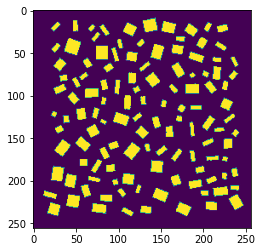

In [10]:
# Load the saved cae for building

## for building
class Autoencoder_building(nn.Module):
    def __init__(self):
        super(Autoencoder_building, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_building = Autoencoder_building()  # Assuming you have the ConvAutoencoder class defined
autoencoder_building.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/autoencoder_Flow_Building_256_256_2000epochs.pth'))

autoencoder_building.eval()  # Set the autoencoder to evaluation mode

print(Latent_data_Building.shape)
input_data = torch.from_numpy(Latent_data_Building[0]).float()
print(input_data.shape)
res = autoencoder_building.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

plt.figure()
plt.imshow(output_data[0])

In [11]:
# Set a seed for reproducibility
np.random.seed(42)

# Get the indices of 0 values
sensors_indices = np.argwhere(output_data <= 0.00001)

# Number of points to randomly select
num_points_to_select = 10

# Randomly select indices
selected_indices = sensors_indices[np.random.choice(len(sensors_indices), size=num_points_to_select, replace=False)]

# Print the selected indices
print("Selected Indices:")
print(selected_indices)

Selected Indices:
[[  0  37  66]
 [  0 102  27]
 [  0  87 148]
 [  0  67 245]
 [  0 105 156]
 [  0 195 133]
 [  0  78 130]
 [  0 181 199]
 [  0 177  70]
 [  0 166 103]]


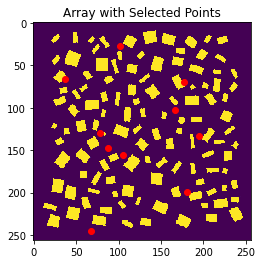

In [12]:
# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

plt.title('Array with Selected Points')
plt.show()

In [13]:
sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

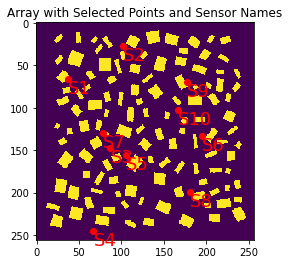

In [14]:
import matplotlib.pyplot as plt

sensor_names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]

# Visualize the array and selected points
plt.imshow(output_data[0], interpolation='none')

# Plot selected points as red dots
plt.scatter(selected_indices[:, 1], selected_indices[:, 2], color='red', marker='o')

# Annotate each point with the corresponding sensor name
for i, name in enumerate(sensor_names):
    plt.text(selected_indices[i, 1], selected_indices[i, 2], name, color='red', fontsize=18, ha='left', va='top')

plt.title('Array with Selected Points and Sensor Names')
plt.show()


#### Create sensors

In [15]:
sensors_x = selected_indices[:, 1]
sensors_y = selected_indices[:, 2]

### Combine Velocity and Building

In [16]:
n_sampels = 300
t_gaps_sampels = 1  ## 10 used to train the model
dt = 5
ntimes = 3

batch_size = 16  # Choose your desired batch size

samples_training = []
samples_training_X = []
samples_training_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_training[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_training[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s_building, s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent)), axis=1)   # X 3 timesteps
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X 2 timesteps
    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_training.append(ss)
    samples_training_X.append(ss_0)
    samples_training_Y.append(ss_1) # Set the autoencoder to evaluation mode

(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 6

In [17]:
samples_training_X_stacked = (np.stack(samples_training_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_training_X_stacked.shape)

(300, 112, 64, 64)


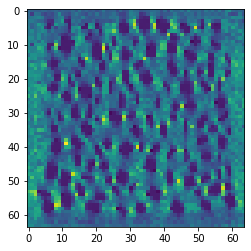

In [18]:
plt.imshow(samples_training_X_stacked[0][33])

In [19]:
samples_training_Y_stacked = (np.stack(samples_training_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_training_Y_stacked.shape)

(300, 112, 64, 64)


(array([353828.,  92070.,   6912.,   1881.,    786.,    908.,    769.,
           641.,    553.,    404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

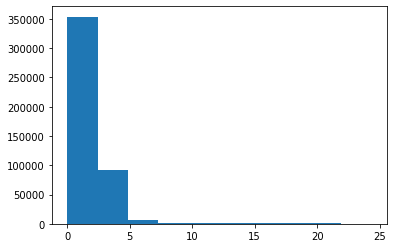

In [20]:
plt.hist(samples_training_X_stacked[0].flatten())

(array([26042., 29981.,  3704.,  1751.,   783.,   908.,   769.,   641.,
          553.,   404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

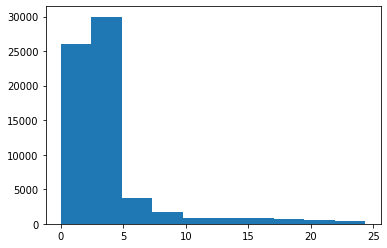

In [21]:
plt.hist(Latent_data_Building.flatten())

## Create data loader

In [22]:
data = samples_training
print(len(data))

300


In [23]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        sample = {'input': self.data_x[idx], 'target': self.data_y[idx]}
        return sample

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Create a DataLoader for batching and shuffling the data

shuffle = False  # Set to True if you want to shuffle the data during training

data_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)


In [24]:
from torch.utils.data import Dataset, DataLoader, random_split

split_ratio = 0.9

# Calculate the sizes of the training and validation sets
total_size = len(samples_training_X_stacked)
train_size = int(split_ratio * total_size)
val_size = total_size - train_size

# Create an instance of your custom dataset
my_dataset = MyDataset(samples_training_X_stacked, samples_training_Y_stacked)

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(my_dataset, [train_size, val_size])

# Create DataLoader instances for training and validation
batch_size = 16 
shuffle_train = False
shuffle_val = False  # Validation data doesn't need to be shuffled

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)

## Define the model

### AAE

In [25]:
# Encoder and Decoder (same as before)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=0),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=5, stride=1, padding=2),
            nn.Identity(),
            # Add more convolutional layers as needed
        )

    def forward(self, x):
        return self.decoder(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# Initialize the components of the AAE
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()

# Initialize the AAE
aae = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Print a summary of the AAE
# Replace (3, 256, 256) with the shape of your input data
summary(aae, input_size=(112, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]         179,264
         LeakyReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4          [-1, 128, 60, 60]         204,928
         LeakyReLU-5          [-1, 128, 60, 60]               0
       BatchNorm2d-6          [-1, 128, 60, 60]             256
           Encoder-7          [-1, 128, 60, 60]               0
   ConvTranspose2d-8           [-1, 64, 64, 64]         204,864
         LeakyReLU-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
  ConvTranspose2d-11          [-1, 112, 64, 64]         179,312
         Identity-12          [-1, 112, 64, 64]               0
          Decoder-13          [-1, 112, 64, 64]               0
           Conv2d-14           [-1, 64,

### AAE from Ventilation

In [89]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(ss_0.shape[1], 256, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, ss_1.shape[1], kernel_size=(3, 3), stride=1, padding=1, output_padding=0, bias=False),
            nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)
    
# Adversarial Autoencoder (AAE)
class AdversarialAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, discriminator):
        super(AdversarialAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        discriminated = self.discriminator(encoded)
        return decoded, discriminated

## Train model

In [227]:
# Instantiate components and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)
aae_model = AdversarialAutoencoder(encoder, decoder, discriminator).to(device)

# Loss functions
reconstruction_loss_fn = nn.MSELoss()
adversarial_loss_fn = nn.BCELoss()

# Optimizers
lr_ae = 0.001
lr_d = 0.001
lr_ed = 0.005

optimizer_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr_ae)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_ed = optim.Adam(encoder.parameters(), lr=lr_ed)

Running on GPU: GeForce RTX 2080 Ti
Epoch [1/500], AE Loss: 9.0548, D Loss: 1.2844, ED Loss: 0.8709
Epoch [2/500], AE Loss: 3.0576, D Loss: 1.0928, ED Loss: 1.0692
Epoch [3/500], AE Loss: 2.5510, D Loss: 0.8967, ED Loss: 1.2440
Epoch [4/500], AE Loss: 2.1550, D Loss: 0.7379, ED Loss: 1.3105
Epoch [5/500], AE Loss: 1.6031, D Loss: 0.6004, ED Loss: 1.4710
Epoch [6/500], AE Loss: 1.2755, D Loss: 0.4834, ED Loss: 1.7216
Epoch [7/500], AE Loss: 1.0246, D Loss: 0.3995, ED Loss: 1.8940
Epoch [8/500], AE Loss: 0.8870, D Loss: 0.3329, ED Loss: 2.1061
Epoch [9/500], AE Loss: 0.8130, D Loss: 0.2921, ED Loss: 2.2742
Epoch [10/500], AE Loss: 0.7151, D Loss: 0.2598, ED Loss: 2.4599
Epoch [11/500], AE Loss: 0.6443, D Loss: 0.2133, ED Loss: 2.5190
Epoch [12/500], AE Loss: 0.5859, D Loss: 0.1839, ED Loss: 2.6715
Epoch [13/500], AE Loss: 0.5500, D Loss: 0.1595, ED Loss: 2.7973
Epoch [14/500], AE Loss: 0.4998, D Loss: 0.1426, ED Loss: 2.9205
Epoch [15/500], AE Loss: 0.4616, D Loss: 0.1301, ED Loss: 3.089

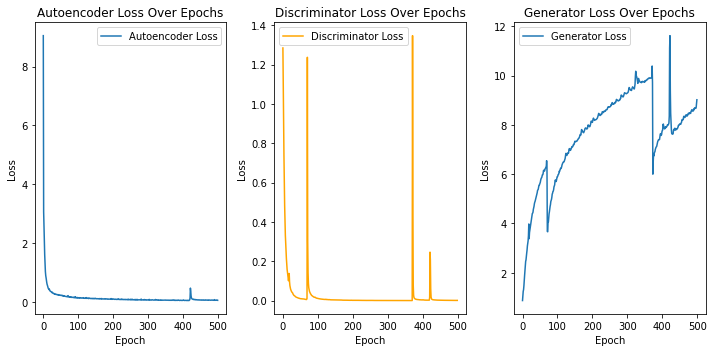

Training finished.
Moved model back to cpu.


In [50]:
num_epochs = 500

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []
all_losses_ed = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []
    epoch_losses_ed = []

    for batch in data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train discriminator
        optimizer_d.zero_grad()
        with torch.no_grad():
            encoded_fake = encoder(inputs).detach()
            encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())

        # Train encoder/generator
        optimizer_ed.zero_grad()
        with torch.no_grad():
            encoded_fool = encoder(inputs).detach()
        fake_output = discriminator(encoded_fool)
        loss_ed = adversarial_loss_fn(fake_output, torch.ones_like(fake_output).to(device))
        loss_ed.backward()
        optimizer_ed.step()
        epoch_losses_ed.append(loss_ed.item())

    # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)
    avg_loss_ed = sum(epoch_losses_ed) / len(epoch_losses_ed)

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}, ED Loss: {avg_loss_ed:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)
    all_losses_ed.append(avg_loss_ed)

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 3, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 3, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ED Loss Plot
plt.subplot(1, 3, 3)
plt.plot(all_losses_ed, label='Generator Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to cpu.")

In [231]:
# Initialize a new run
wandb.init(project="LatentPrediction", name="my-run")
# Log the model with wandb
wandb.watch(aae_model)

# Set the checkpoint directory
checkpoint_dir = '/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatentNew0215_'
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 5000

# Set the checkpoint frequency (save every n epochs)
checkpoint_freq = 100

# Lists to store losses for plotting
all_losses_ae = []
all_losses_d = []
all_losses_ed = []
all_losses_ae_val = []

# Print the GPU device
print(f"Running on GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Training loop
for epoch in range(num_epochs):
    epoch_losses_ae = []
    epoch_losses_d = []
    epoch_losses_ed = []

    for batch in train_data_loader:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Train autoencoder/predictor
        optimizer_ae.zero_grad()
        decoded, discriminated = aae_model(inputs)
        print(decoded.shape)
        print(targets.shape)
        loss_ae = reconstruction_loss_fn(decoded, targets)
        loss_ae.backward()
        optimizer_ae.step()
        epoch_losses_ae.append(loss_ae.item())

        # Train encoder/generator
        optimizer_ed.zero_grad()
        encoded_fool = encoder(inputs)
        fake_output = discriminator(encoded_fool)
        loss_ed = adversarial_loss_fn(fake_output, torch.ones_like(fake_output).to(device))
        loss_ed.backward()
        optimizer_ed.step()
        epoch_losses_ed.append(loss_ed.item())

        # Train discriminator
        optimizer_d.zero_grad()
        encoded_fake = encoder(inputs).detach()
        encoded_true = torch.randn_like(encoded_fake).to(device)   # the true sample
        fake_output = discriminator(encoded_fake)
        true_output = discriminator(encoded_true)
        loss_d = adversarial_loss_fn(fake_output, torch.zeros_like(fake_output).to(device)) + \
                 adversarial_loss_fn(true_output, torch.ones_like(true_output).to(device))
        loss_d.backward()
        optimizer_d.step()
        epoch_losses_d.append(loss_d.item())
    
    # Validation phase
    with torch.no_grad():
        for val_batch in val_data_loader:  # Assuming you have a separate val_data_loader for validation
            val_inputs, val_targets = val_batch['input'].to(device), val_batch['target'].to(device)
            val_decoded, val_discriminated = aae_model(val_inputs)
            val_loss_ae = reconstruction_loss_fn(val_decoded, val_targets).item()
            val_loss_d = 0  # Adjust as needed for discriminator loss in validation
            val_loss_ed = 0  # Adjust as needed for encoder/generator loss in validation

            # Record validation losses
            all_losses_ae_val.append(val_loss_ae)

        # Average losses over the epoch
    avg_loss_ae = sum(epoch_losses_ae) / len(epoch_losses_ae)
    avg_loss_d = sum(epoch_losses_d) / len(epoch_losses_d)
    avg_loss_ed = sum(epoch_losses_ed) / len(epoch_losses_ed)
    avg_loss_ed_val = sum(all_losses_ae_val) / len(all_losses_ae_val)

    # Log metrics to wandb
    wandb.log({
        "AE Loss": avg_loss_ae,
        "D Loss": avg_loss_d,
        "ED Loss": avg_loss_ed,
        "Val AE Loss": avg_loss_ed_val,
    })

    # Print the average loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], AE Loss: {avg_loss_ae:.4f}, D Loss: {avg_loss_d:.4f}, ED Loss: {avg_loss_ed:.4f}, Val AE Loss: {val_loss_ae:.4f}')

    # Record the losses for plotting
    all_losses_ae.append(avg_loss_ae)
    all_losses_d.append(avg_loss_d)
    all_losses_ed.append(avg_loss_ed)

    # Save checkpoint
    if (epoch + 1) % checkpoint_freq == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch + 1}.pth')
        print(checkpoint_path)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': aae_model.state_dict(),
            'optimizer_ae_state_dict': optimizer_ae.state_dict(),
            'optimizer_d_state_dict': optimizer_d.state_dict(),
            'optimizer_ed_state_dict': optimizer_ed.state_dict(),
            'all_losses_ae': all_losses_ae,
            'all_losses_d': all_losses_d,
            'all_losses_ed': all_losses_ed,
            'all_losses_ae_val': all_losses_ae_val,
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch + 1}.')

# Plot the losses separately
plt.figure(figsize=(10, 5))

# Autoencoder Loss Plot
plt.subplot(1, 3, 1)
plt.plot(all_losses_ae, label='Autoencoder Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator Loss Plot
plt.subplot(1, 3, 2)
plt.plot(all_losses_d, label='Discriminator Loss', color='orange')
plt.title('Discriminator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ED Loss Plot
plt.subplot(1, 3, 3)
plt.plot(all_losses_ed, label='Generator Loss')
plt.title('Generator Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished.")
aae_model = aae_model.cpu()
print("Moved model back to CPU.")

2024-02-15 13:56:56.029202: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Running on GPU: GeForce RTX 2080 Ti
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torch.Size([16, 112, 64, 64])
torc

## Load saved model - checkpoint

In [67]:
checkpoint = torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/Flow_Data/PredictionModel/autoencoder_Flow_PredictionLatentNew0215_/checkpoint_epoch_700.pth')

In [68]:
# Load the saved autoencoder
encoder = Encoder()
decoder = Decoder()
discriminator = Discriminator()
autoencoderP = AdversarialAutoencoder(encoder, decoder, discriminator)
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_32batchsize_lr0.003_updatedLoss.pth'))
# autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/interpolation_code_example_2D/models/Velocity256_Compression_1000epochs_64batchsize_lr0.003_updatedLoss.pth'))


autoencoderP.load_state_dict(checkpoint['model_state_dict'])

autoencoderP.eval()  # Set the autoencoder to evaluation mode

aae_model = autoencoderP

In [69]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the input size is (channels, height, width)
input_size = (ss_0.shape[1], ss_0.shape[2], ss_0.shape[3])

summary(autoencoderP.to(device), input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]         179,264
         LeakyReLU-2           [-1, 64, 64, 64]               0
       BatchNorm2d-3           [-1, 64, 64, 64]             128
            Conv2d-4          [-1, 128, 60, 60]         204,928
         LeakyReLU-5          [-1, 128, 60, 60]               0
       BatchNorm2d-6          [-1, 128, 60, 60]             256
           Encoder-7          [-1, 128, 60, 60]               0
   ConvTranspose2d-8           [-1, 64, 64, 64]         204,864
         LeakyReLU-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
  ConvTranspose2d-11          [-1, 112, 64, 64]         179,312
         Identity-12          [-1, 112, 64, 64]               0
          Decoder-13          [-1, 112, 64, 64]               0
           Conv2d-14           [-1, 64,

In [70]:
aae_model = autoencoderP

## Generate result plots

### Load CAE model

In [71]:
## for velocity
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU()
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),  # Change kernel_size and stride to 2
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=2, stride=2, padding=0),   # Change kernel_size and stride to 2
            nn.Identity()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load the saved autoencoder
autoencoder = Autoencoder()  # Assuming you have the ConvAutoencoder class defined
autoencoder.load_state_dict(torch.load('/home/dg321/gitTest/PRI/irp/FlowPassBuilding/MainCodes/models/Velocity256_Compression_1500epochs_32batchsize_lr0.001_326464.pth'))

autoencoder.eval()  # Set the autoencoder to evaluation mode

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(2, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 2, kernel_size=(2, 2), stride=(2, 2))
    (3): Identity()
  )
)

In [72]:
sample = samples_training_Y_stacked[1]
print(sample.shape)

(112, 64, 64)


In [73]:
input_data = torch.from_numpy(sample[:32,:,:]).unsqueeze(0).float()
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)

torch.Size([1, 32, 64, 64])
(1, 2, 256, 256)


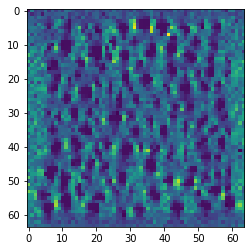

In [77]:
plt.imshow(samples_training_Y_stacked[0][16])

### Predict

In [78]:
id = 1
sampleX = torch.from_numpy((samples_training_X_stacked[id]).reshape(1,ss_0.shape[1],xysize_latent,xysize_latent)).float()
sampleTarget = torch.from_numpy((samples_training_Y_stacked[id]).reshape(1,ss_1.shape[1],xysize_latent,xysize_latent)).float()
print(sampleX.shape)
print(sampleTarget.shape)

torch.Size([1, 112, 64, 64])
torch.Size([1, 112, 64, 64])


In [79]:
with torch.no_grad():
    aae_model.eval().cpu()  # Set the model to evaluation mode
    prediction = aae_model(sampleX)

prediction = prediction[0]

In [80]:
print(prediction.shape)

torch.Size([1, 112, 64, 64])


torch.Size([1, 112, 64, 64])


(array([351508.,  94103.,   7178.,   1902.,    786.,    908.,    769.,
           641.,    553.,    404.]),
 array([ 0.       ,  2.4357257,  4.8714514,  7.3071775,  9.742903 ,
        12.178629 , 14.614355 , 17.050081 , 19.485806 , 21.921532 ,
        24.357258 ], dtype=float32),
 <BarContainer object of 10 artists>)

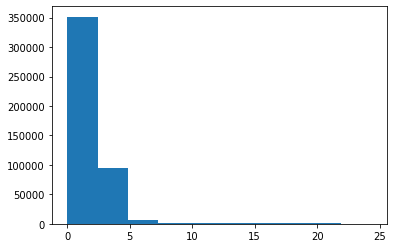

In [81]:
print(sampleTarget.shape)
plt.hist(sampleTarget.flatten())

torch.Size([1, 112, 64, 64])


(array([1.74928e+05, 2.52818e+05, 2.45060e+04, 2.48900e+03, 7.66000e+02,
        8.93000e+02, 8.10000e+02, 7.26000e+02, 5.71000e+02, 2.45000e+02]),
 array([-1.5519801,  1.2973611,  4.1467023,  6.9960437,  9.845386 ,
        12.694726 , 15.544067 , 18.39341  , 21.24275  , 24.092093 ,
        26.941433 ], dtype=float32),
 <BarContainer object of 10 artists>)

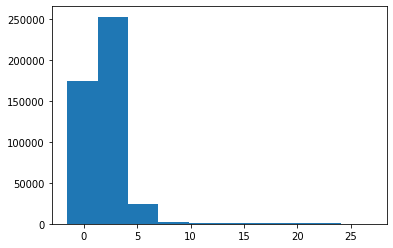

In [82]:
print(prediction.shape)
plt.hist(prediction.flatten())

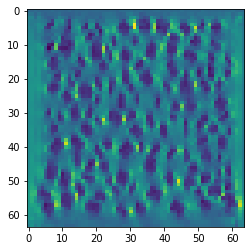

In [83]:
plt.imshow(prediction[0][33])

In [84]:
print(prediction.shape)

torch.Size([1, 112, 64, 64])


torch.Size([1, 32, 64, 64])
(1, 2, 256, 256)


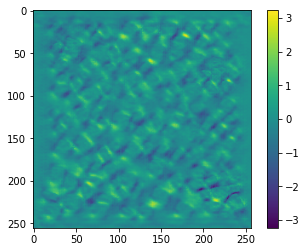

In [86]:
# input_data = torch.from_numpy(prediction).unsqueeze(0).float()
# input_data = prediction[:1, :, :, :]
input_data = prediction[:1, 16 + 64:16 + 96, :, :]
print(input_data.shape)
res = autoencoder.decoder(input_data)
output_data = res.detach().numpy()
print(output_data.shape)
plt.figure()
plt.imshow(output_data[0,1])
cbar = plt.colorbar()

In [87]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [88]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_training_X_stacked[id_sample]
    sampleY = samples_training_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16:16+32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16+32:16+32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16+32+32:16+32+32+32,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 16+64:16+96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')

In [89]:
for i in range(1,60,1):
    plot_results_together(i)

prediction error: 0.071898706
prediction error: 0.07294729
prediction error: 0.073909305
prediction error: 0.07468347
prediction error: 0.075474784
prediction error: 0.07619999
prediction error: 0.07675765
prediction error: 0.07718406
prediction error: 0.07770263
prediction error: 0.07812397
prediction error: 0.07843925
prediction error: 0.078688115
prediction error: 0.078992836
prediction error: 0.079494
prediction error: 0.08005544
prediction error: 0.08075225
prediction error: 0.0815121
prediction error: 0.082311414
prediction error: 0.083027855
prediction error: 0.07715089
prediction error: 0.08447544
prediction error: 0.08522588
prediction error: 0.08596857
prediction error: 0.08661531
prediction error: 0.08740396
prediction error: 0.08835731
prediction error: 0.089119375
prediction error: 0.089866005
prediction error: 0.09060358
prediction error: 0.09165451
prediction error: 0.092754975
prediction error: 0.09381975
prediction error: 0.09485502
prediction error: 0.09599338
predict

### Predict for test

In [90]:
n_sampels = 10
t_gaps_sampels = 2
dt = 5
ntimes = 3

batch_size = 1  # Choose your desired batch size

samples_test = []
samples_test_X = []
samples_test_Y = []

for i in range(1, n_sampels+1):
    ii = 1 + i*t_gaps_sampels
    # s = np.concatenate([Latent_data_VelocityXs_test[ss] for ss in range(ii,ii + dt*ntimes, dt )], axis = 0)
    s = np.stack([Latent_data_Velocity_test[ss] for ss in range(ii,ii + dt*ntimes, dt )])
    s_building = Latent_data_Building
    # ss_0 = np.concatenate((s[0].reshape(1, 32, xysize_latent, xysize_latent), s_building), axis=1)   # X
    ss_0 = np.concatenate((s_building, s[0].reshape(1, 32, xysize_latent, xysize_latent), s[1].reshape(1, 32, xysize_latent, xysize_latent), s[2].reshape(1, 32, xysize_latent, xysize_latent)), axis=1)   # X

    # ss_1 = s[2].reshape(1, 32, xysize_latent, xysize_latent)   # Y
    ss_1 = ss_0


    ss = (ss_0, ss_1)
    print(ss[0].shape)
    print(ss[1].shape)
    samples_test.append(ss)
    samples_test_X.append(ss_0)
    samples_test_Y.append(ss_1)


samples_test_X_stacked = (np.stack(samples_test_X)).reshape(n_sampels, ss_0.shape[1], xysize_latent, xysize_latent)
print(samples_test_X_stacked.shape)

samples_test_Y_stacked = (np.stack(samples_test_Y)).reshape(n_sampels, ss_1.shape[1], xysize_latent, xysize_latent)
print(samples_test_Y_stacked.shape)

(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(1, 112, 64, 64)
(10, 112, 64, 64)
(10, 112, 64, 64)


In [91]:
autoencoderP = aae_model

In [92]:
# Plot the results together

def plot_results_together(id_sample):
    velocity_field = 0

    sampleX = samples_test_X_stacked[id_sample]
    sampleY = samples_test_Y_stacked[id_sample]


    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16:16+32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16+32:16+32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[16+32+32:16+32+32+32,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    # switch models here
    # prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())
    prediction = aae_model(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, 16+64:16+96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')

In [93]:
for i in range(1,10):
    plot_results_together(i)

prediction error: 0.16225983
prediction error: 0.15999526
prediction error: 0.1592646
prediction error: 0.16269681
prediction error: 0.17203596
prediction error: 0.18170694
prediction error: 0.18121417
prediction error: 0.17044893
prediction error: 0.16429551


# Predict iteratively

In [94]:
autoencoderP = aae_model

prediction error: 0.071898706


<Figure size 432x288 with 0 Axes>

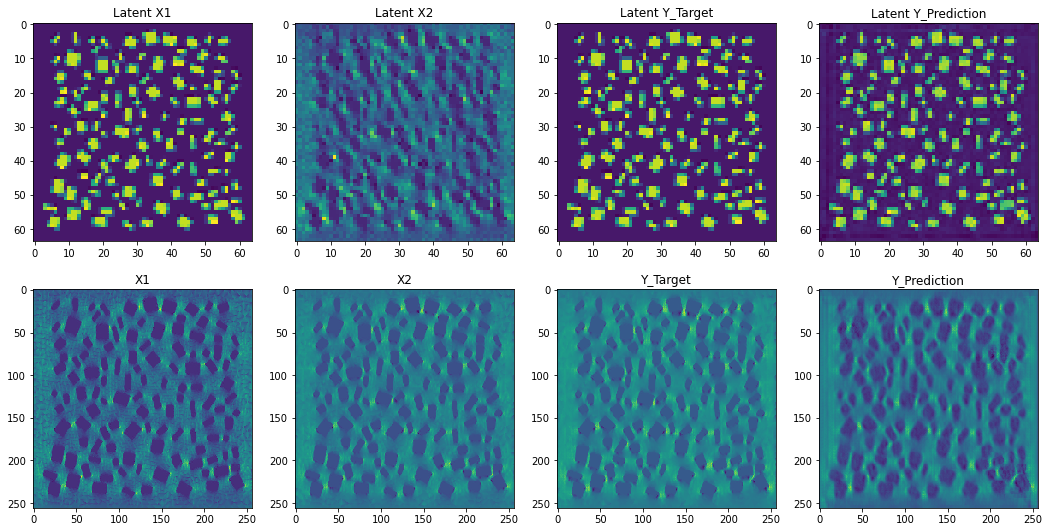

In [95]:
building_channels = 16

id_sample = 1

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels:building_channels+32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels+32:building_channels+32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels+32+32:building_channels+32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, building_channels+64:building_channels+96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)


plt.figure()

f, axarr = plt.subplots(2,4, figsize=(18, 9))

# plot latent space
sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
axarr[0][0].title.set_text('Latent X1')

sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
axarr[0][1].title.set_text('Latent X2')

sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
axarr[0][2].title.set_text('Latent Y_Target')

sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
axarr[0][3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[1][0].title.set_text('X1')

sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1][1].title.set_text('X2')

sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[1][2].title.set_text('Y_Target')

sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[1][3].title.set_text('Y_Prediction')

In [96]:
building_channels = 16
losses = []
losses_2pts_latent = []
n_iters = 150



id_sample = 20

velocity_field = 0

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_Y_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels:building_channels+32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels+32:building_channels+32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels+32+32:building_channels+32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

sampleX[building_channels+32+32:building_channels+32+32+32,:,:] = sampleX[building_channels+32:building_channels+32+32,:,:]
prediction = autoencoderP(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, building_channels+64:building_channels+96, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)
losses.append(loss)

loss_2pts_latent = mse_loss(prediction[:1, building_channels:building_channels+64, :, :].detach().numpy(), sampleX[building_channels:building_channels+64,:,:])
losses_2pts_latent.append(loss_2pts_latent)

# plt.figure()

# f, axarr = plt.subplots(2,4, figsize=(18, 9))

# # plot latent space
# sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
# axarr[0][0].title.set_text('Latent X1')

# sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
# axarr[0][1].title.set_text('Latent X2')

# sub3 = axarr[0][2].imshow(sampleY[0], interpolation='none')
# axarr[0][2].title.set_text('Latent Y_Target')

# sub4 = axarr[0][3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[0][3].title.set_text('Latent Y_Prediction')

# # plot decoded space
# sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
# axarr[1][0].title.set_text('X1')

# sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
# axarr[1][1].title.set_text('X2')

# sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
# axarr[1][2].title.set_text('Y_Target')

# sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
# axarr[1][3].title.set_text('Y_Prediction')

prediction_new = prediction


for i in range(n_iters):

    sampleX = samples_training_X_stacked[id_sample]
    sampleX_new = sampleX.copy()
    prediction = prediction_new.detach().numpy()
    sampleX_new[building_channels+64:building_channels+64+32] = prediction[0,building_channels+64:building_channels+64+32]

    prediction_new = autoencoderP(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction_new[:1, building_channels+64:building_channels+64+32, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()

    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)
    losses.append(loss)

    loss_2pts_latent = mse_loss(prediction_new[:1, building_channels:building_channels+64, :, :].detach().numpy(), sampleX[building_channels:building_channels+64,:,:])
    losses_2pts_latent.append(loss_2pts_latent)

    # plt.figure()

    # f, axarr = plt.subplots(2,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0][0].imshow(sampleX[0], interpolation='none')
    # axarr[0][0].title.set_text('Latent X1')

    # sub2 = axarr[0][1].imshow(sampleX[32], interpolation='none')
    # axarr[0][1].title.set_text('Latent X2')

    # sub3 = axarr[0][2].imshow(sampleX_new[64], interpolation='none')
    # axarr[0][2].title.set_text('Latent Y_Target')

    # sub4 = axarr[0][3].imshow((prediction_new.detach().numpy())[0][0], interpolation='none')
    # axarr[0][3].title.set_text('Latent Y_Prediction')

    # # plot decoded space
    # sub11 = axarr[1][0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[1][0].title.set_text('X1')

    # sub12 = axarr[1][1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1][1].title.set_text('X2')

    # sub13 = axarr[1][2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[1][2].title.set_text('Y_Target')

    # sub14 = axarr[1][3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[1][3].title.set_text('Y_Prediction')

prediction error: 0.07715089
prediction error: 0.104252204
prediction error: 0.12012216
prediction error: 0.1298321
prediction error: 0.1358192
prediction error: 0.13957532
prediction error: 0.14196637
prediction error: 0.14350581
prediction error: 0.14450622
prediction error: 0.1451605
prediction error: 0.1455935
prediction error: 0.14588264
prediction error: 0.14607707
prediction error: 0.14620863
prediction error: 0.14629805
prediction error: 0.14635885
prediction error: 0.14640017
prediction error: 0.14642812
prediction error: 0.14644706
prediction error: 0.14645979
prediction error: 0.14646831
prediction error: 0.14647405
prediction error: 0.14647774
prediction error: 0.14648028
prediction error: 0.14648196
prediction error: 0.1464831
prediction error: 0.14648381
prediction error: 0.14648423
prediction error: 0.1464845
prediction error: 0.14648464
prediction error: 0.14648476
prediction error: 0.14648484
prediction error: 0.14648487
prediction error: 0.1464849
prediction error: 0.

In [97]:
print(len(losses))

151


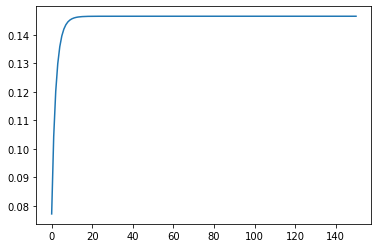

In [98]:
plt.plot(losses[:])

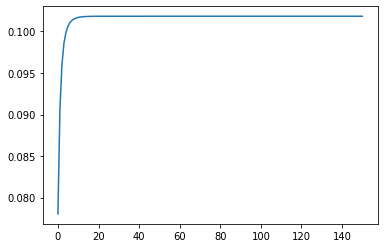

In [99]:
plt.plot(losses_2pts_latent[:])

# Time stepping - predict forward in time

In [100]:
def mse_loss(image1, image2):
    """
    Compute the Mean Squared Error (MSE) loss between two images.

    Parameters:
        - image1: NumPy array representing the first image
        - image2: NumPy array representing the second image

    Returns:
        - mse: MSE loss value
    """
    mse = np.mean((image1 - image2)**2)
    return mse


In [105]:
def run_iteration(sample_input, n_iters=1):

    SampleX = sample_input.clone()

    losses_2pts_latent = []

    prediction = autoencoderP(SampleX.float())[0]

    loss_2pts_latent = mse_loss(prediction[:1, building_channels:building_channels+64, :, :].detach().numpy(), SampleX[:1, building_channels:building_channels+64, :, :].detach().numpy())
    losses_2pts_latent.append(loss_2pts_latent)

    prediction_new = prediction

    for i in range(n_iters):
        sampleX_new = sample_input.clone()
        prediction = prediction_new
        # print(sampleX_new.shape)
        # print(prediction.shape)
        sampleX_new[0, building_channels+64:building_channels+64 + 32] = prediction[0, building_channels+64:building_channels+64 + 32]

        prediction_new = autoencoderP(sampleX_new.float())[0]
    
        loss_2pts_latent = mse_loss(prediction_new[:1, building_channels:building_channels+64, :, :].detach().numpy(), SampleX[:1, building_channels:building_channels+64, :, :].detach().numpy())
        losses_2pts_latent.append(loss_2pts_latent)

    return prediction_new, losses_2pts_latent

prediction error: 0.09343623
prediction error: 0.21391799
prediction error: 0.34830928
prediction error: 75.9525
prediction error: 14366958000000.0
prediction error: 1.6955427e+25


<Figure size 432x288 with 0 Axes>

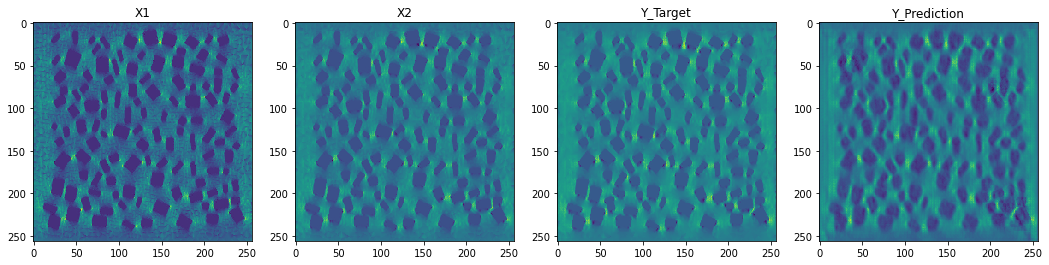

In [106]:
# can change run_iteration to autoencoderP

num_time_stepping = 5
velocity_field = 0
id_sample = 1

Samples_Ytargets = []
Samples_Predictions = []

sensor_values_X1 = []
sensor_values_X2 = []
sensor_values_Ytarget = []
sensor_values_prediction = []

timelevels = []

hist_data_predictions = []
hist_data_ground_truth = []
fft_data_predictions = []
fft_data_ground_truth = []

sampleX = samples_training_X_stacked[id_sample]
sampleY = samples_training_X_stacked[id_sample]


X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels:building_channels+32,:,:]).unsqueeze(0).float())
X1_decoded = X1_decoded.detach().numpy()

X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX[building_channels+32:building_channels+32+32,:,:]).unsqueeze(0).float())
X2_decoded = X2_decoded.detach().numpy()

Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY[building_channels+32+32:building_channels+32+32+32,:,:]).unsqueeze(0).float())
Y_decoded = Y_decoded.detach().numpy()

prediction = run_iteration(torch.from_numpy(sampleX).unsqueeze(0).float())[0]

prediction_decoded = autoencoder.decoder(prediction[:1, building_channels+32+32:building_channels+32+32+32, :, :])
prediction_decoded = prediction_decoded.detach().numpy()


Samples_Ytargets.append(Y_decoded)
Samples_Predictions.append(prediction_decoded)

# get histogram
hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

hist_data_predictions.append((hist_prediction, bins_prediction))
hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

# get FFT
fft_prediction = np.fft.fft(prediction_decoded.flatten())
fft_ground_truth = np.fft.fft(Y_decoded.flatten())

fft_data_predictions.append(fft_prediction)
fft_data_ground_truth.append(fft_ground_truth)

# get sensor data
sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
print("prediction error:", loss)

timelevel = id_sample*t_gaps_sampels + dt*2 # for training

timelevels.append(timelevel)

plt.figure()

f, axarr = plt.subplots(1,4, figsize=(18, 9))

# plot latent space
# sub1 = axarr[0].imshow(sampleX[0], interpolation='none')
# axarr[0].title.set_text('Latent X1')

# sub2 = axarr[1].imshow(sampleX[32], interpolation='none')
# axarr[1].title.set_text('Latent X2')

# sub3 = axarr[2].imshow(sampleY[0], interpolation='none')
# axarr[2].title.set_text('Latent Y_Target')

# sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
# axarr[3].title.set_text('Latent Y_Prediction')

# plot decoded space
sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
axarr[0].title.set_text('X1')

sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
axarr[1].title.set_text('X2')

sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
axarr[2].title.set_text('Y_Target')

sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
axarr[3].title.set_text('Y_Prediction')


for n in range(num_time_stepping):    
    sampleX_new = sampleX.copy()
    sampleX_new[building_channels:building_channels+32] = sampleX[building_channels+32:building_channels+64]
    sampleX_new[building_channels+32:building_channels+64] = (prediction.detach().numpy())[0, building_channels+64:building_channels+96]
    sampleX_new[building_channels+64:building_channels+96] = sampleX_new[building_channels+32:building_channels+64]

    sampleY_new = Latent_data_Velocity_training[1 + id_sample*t_gaps_sampels + dt*(4 + n)]

    X1_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[building_channels:building_channels+32,:,:]).unsqueeze(0).float())
    X1_decoded = X1_decoded.detach().numpy()

    X2_decoded = autoencoder.decoder(torch.from_numpy(sampleX_new[building_channels+32:building_channels+32+32,:,:]).unsqueeze(0).float())
    X2_decoded = X2_decoded.detach().numpy()

    Y_decoded = autoencoder.decoder(torch.from_numpy(sampleY_new[:,:,:]).unsqueeze(0).float())
    Y_decoded = Y_decoded.detach().numpy()

    prediction = run_iteration(torch.from_numpy(sampleX_new).unsqueeze(0).float())[0]

    prediction_decoded = autoencoder.decoder(prediction[:1, building_channels+64:building_channels+96, :, :])
    prediction_decoded = prediction_decoded.detach().numpy()
    
    Samples_Ytargets.append(Y_decoded)
    Samples_Predictions.append(prediction_decoded)

    # get histogram
    hist_prediction, bins_prediction = np.histogram(prediction_decoded.flatten(), bins=50)
    hist_ground_truth, bins_ground_truth = np.histogram(Y_decoded.flatten(), bins=50)

    hist_data_predictions.append((hist_prediction, bins_prediction))
    hist_data_ground_truth.append((hist_ground_truth, bins_ground_truth))

    # get FFT
    fft_prediction = np.fft.fft(prediction_decoded.flatten())
    fft_ground_truth = np.fft.fft(Y_decoded.flatten())

    fft_data_predictions.append(fft_prediction)
    fft_data_ground_truth.append(fft_ground_truth)

    # get sensor data
    sensor_values_prediction.append(prediction_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X1.append(X1_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_X2.append(X2_decoded[0,velocity_field, sensors_x, sensors_y])
    sensor_values_Ytarget.append(Y_decoded[0,velocity_field, sensors_x, sensors_y])

    timelevel = timelevel + dt
    timelevels.append(timelevel)


    loss = mse_loss(Y_decoded.flatten(), prediction_decoded.flatten())
    print("prediction error:", loss)


    # plt.figure()

    # f, axarr = plt.subplots(1,4, figsize=(18, 9))

    # # plot latent space
    # sub1 = axarr[0].imshow(sampleX_new[0], interpolation='none')
    # axarr[0].title.set_text('Latent X1')

    # sub2 = axarr[1].imshow(sampleX_new[32], interpolation='none')
    # axarr[1].title.set_text('Latent X2')

    # sub3 = axarr[2].imshow(sampleY_new[0], interpolation='none')
    # axarr[2].title.set_text('Latent Y_Target')

    # sub4 = axarr[3].imshow((prediction.detach().numpy())[0][0], interpolation='none')
    # axarr[3].title.set_text('Latent Y_Prediction')

    # plot decoded space
    # sub11 = axarr[0].imshow(X1_decoded[0][velocity_field], interpolation='none')
    # axarr[0].title.set_text('X1')

    # sub12 = axarr[1].imshow(X2_decoded[0][velocity_field], interpolation='none')
    # axarr[1].title.set_text('X2')

    # sub13 = axarr[2].imshow(Y_decoded[0][velocity_field], interpolation='none')
    # axarr[2].title.set_text('Y_Target')

    # sub14 = axarr[3].imshow(prediction_decoded[0][velocity_field], interpolation='none')
    # axarr[3].title.set_text('Y_Prediction')


    sampleX = sampleX_new.copy()

In [107]:
print(len(Samples_Ytargets))
print(len(Samples_Predictions))

print(len(sensor_values_prediction))
print(len(sensor_values_X1))
print(len(sensor_values_X2))
print(len(sensor_values_Ytarget))
print(len(timelevels))

6
6
6
6
6
6
6


In [108]:
print(Samples_Predictions[0].shape)
print(Samples_Ytargets[0].shape)

numpy_array_Samples_Predictions = np.squeeze(np.stack(Samples_Predictions), axis = 1)
numpy_array_Samples_Ytargets = np.squeeze(np.stack(Samples_Ytargets), axis = 1)

print(numpy_array_Samples_Predictions.shape)
print(numpy_array_Samples_Ytargets.shape)

(1, 2, 256, 256)
(1, 2, 256, 256)
(6, 2, 256, 256)
(6, 2, 256, 256)


In [109]:
numpy_array_prediction = np.array(sensor_values_prediction)
numpy_array_X1 = np.array(sensor_values_X1)
numpy_array_X2 = np.array(sensor_values_X2)
numpy_array_Ytarget = np.array(sensor_values_Ytarget)
numpy_array_timelevels = np.array(timelevels)

# Print the shape of each NumPy array
print("Shape of numpy_array_prediction:", numpy_array_prediction.shape)
print("Shape of numpy_array_X1:", numpy_array_X1.shape)
print("Shape of numpy_array_X2:", numpy_array_X2.shape)
print("Shape of numpy_array_Ytarget:", numpy_array_Ytarget.shape)
print("Shape of numpy_array_timelevels:", numpy_array_timelevels.shape)

Shape of numpy_array_prediction: (6, 10)
Shape of numpy_array_X1: (6, 10)
Shape of numpy_array_X2: (6, 10)
Shape of numpy_array_Ytarget: (6, 10)
Shape of numpy_array_timelevels: (6,)


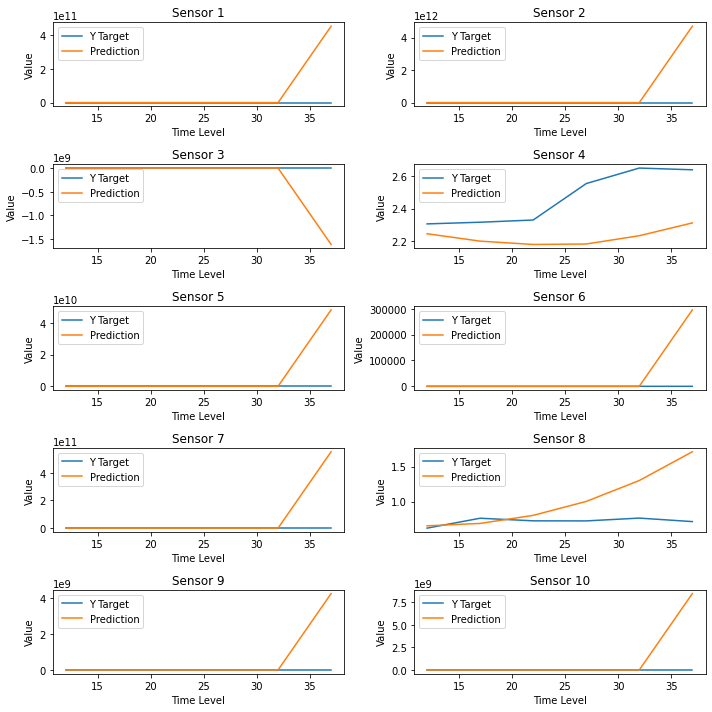

In [110]:
# Create a figure with 10 subplots
fig, axs = plt.subplots(5, 2, figsize=(10, 10))

# Iterate through the samples and create subplots
for i in range(10):
    # Select the i-th sample
    y_target_sample = numpy_array_Ytarget[:, i]
    prediction_sample = numpy_array_prediction[:, i]

    # Determine the subplot position
    row = i // 2
    col = i % 2
    # Plot Y target and prediction in the subplot
    axs[row, col].plot(numpy_array_timelevels, y_target_sample, label='Y Target')
    axs[row, col].plot(numpy_array_timelevels, prediction_sample, label='Prediction')
    axs[row, col].set_title(f'Sensor {i+1}')
    axs[row, col].set_xlabel('Time Level')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()